In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
df_data = pd.read_parquet("training_data/initial_dataset.parquet")
df_train_detached = pd.read_parquet(
    "training_data/data_detached_with_weather.parquet")
type(df_data)
type(df_train_detached)
df_train_detached

unique_ids = df_train_detached["Property_ID"].unique()
id_use = unique_ids[0]
df_house = pd.read_csv('training_data/home_characteristics.csv')

# List of columns to check for missingness
cols = [
    "Bedrooms", "Floor_Height", "Habitable_Rooms", "House_Age",
    "House_Form", "No_Storeys", "No_Underfloor",
    "Total_Floor_Area", "Wall_Type", "MCS_DHWAnnual", "HP_Size_kW"
]

# calculate min capacity in home 
cp_air = 1.005  #kJ/kgK
rho_air = 1.225  # kg/m^3
kj_to_kWh = 1 / 3600
df_house["Volume"] = df_house["Total_Floor_Area"] * df_house["Floor_Height"]
df_house["Min Capacity"] = df_house["Volume"] * cp_air * rho_air * kj_to_kWh

df_home_values = df_house[df_house["Property_ID"].isin(unique_ids)]

summary = df_home_values[["Property_ID", "Min Capacity"]].drop_duplicates()
print(summary)

home_dict = df_home_values.set_index("Property_ID").to_dict(orient="index")
df_single = df_train_detached[
    df_train_detached["Property_ID"] == id_use].copy()

#re-adjust Heat Pump Diff and add temp differences
df_single["Heat_Pump_Energy_Output_Diff"] = df_single[
    "Heat_Pump_Energy_Output"].diff()
df_single["Internal_Temperature_Diff"] = df_single[
    "Internal_Air_Temperature"].diff()
df_single["Internal_Ambient_Temperature_Diff"] = \
    (df_single["External_Air_Temperature"] -
     df_single["Internal_Air_Temperature"])

# 1. Drop columns with almost all missing data (e.g., more than 90% missing)
threshold = 0.90 * len(df_single)
df_single_cleaned = df_single.dropna(axis=1, thresh=threshold)
#print("Columns dropped due to high missing values:")
#print(df_single.columns.difference(df_single_cleaned.columns).tolist())

df_single = df_single_cleaned

#print("\nColumns remaining after dropping highly missing columns:")
#print(df_single.columns.tolist())

df_single = df_single.set_index('Timestamp')
df_single = df_single.sort_index()

# Apply interpolation with a limit of 4 (for 2 hours of half-hourly data)
numeric_cols = df_single.select_dtypes(include=['number']).columns
df_single_numeric_interpolated = df_single[numeric_cols].interpolate(
    method='time', limit=4, limit_direction='both')

df_single_interpolated = df_single.copy()
df_single_interpolated[numeric_cols] = df_single_numeric_interpolated

# After interpolation, drop rows that still contain NaN values (meaning they were missing for > 2 hours)
initial_rows = len(df_single_interpolated)
df_single_processed = df_single_interpolated.dropna()

     Property_ID  Min Capacity
76       EOH3196      0.086941
318      EOH0413      0.094570
585      EOH2329      0.099645
736      EOH1637      0.088733
1149     EOH3154      0.116411
1156     EOH2675      0.124696
1569     EOH1485      0.115696
1692     EOH0546      0.088239
2066     EOH0279      0.138493
2381     EOH1703      0.074688


In [ ]:
df_heating_single = df_single_processed.copy()

# Time range
t_start = pd.to_datetime("2021-10-01 00:00:00")
t_end = pd.to_datetime("2022-3-31 23:59:00")
df_heating_only = df_heating_single[
    (df_heating_single.index >= t_start) & (df_heating_single.index <= t_end)
].copy()

df_heating_only.drop("Property_ID", axis=1, inplace=True)
df_heating_only.drop("half-hour", axis=1, inplace=True)
df_heating_only.drop("Date", axis=1, inplace=True)
df_heating_only.drop("has_data", axis=1, inplace=True)


t_step_try = [6, 12, 24]

for i in t_step_try:
    df_numeric = df_heating_only.select_dtypes(include='number')

    # Resample and compute mean
    df_resampled = df_numeric.resample(f'{i}h').mean()

    # Extract variables
    delta_T_a_heat = df_resampled["Internal_Ambient_Temperature_Diff"]
    q_heat_only = df_resampled["Heat_Pump_Energy_Output_Diff"]
    delta_T_i_heat = df_resampled["Internal_Temperature_Diff"]
    T_ambient = df_resampled["External_Air_Temperature"]
    
    # Create new scatter plot
    plt.figure()
    plt.scatter(delta_T_a_heat, q_heat_only)
    plt.title(f"Ambient Delta Scatter Plot for Time Step = {i} Hour(s)")
    plt.xlabel("Delta Temperature")
    plt.ylabel("Heat Input Q")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    plt.figure()
    plt.scatter(T_ambient, q_heat_only)
    plt.title(f"Ambient Scatter Plot for Time Step = {i} Hour(s)")
    plt.xlabel("Ambient Temperature")
    plt.ylabel("Heat Input Q")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    plt.figure()
    plt.scatter(delta_T_i_heat, q_heat_only)
    plt.title(f"Internal Delta Scatter Plot for Time Step = {i} Hour(s)")
    plt.xlabel("Delta Temperature")
    plt.ylabel("Heat Input Q")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    

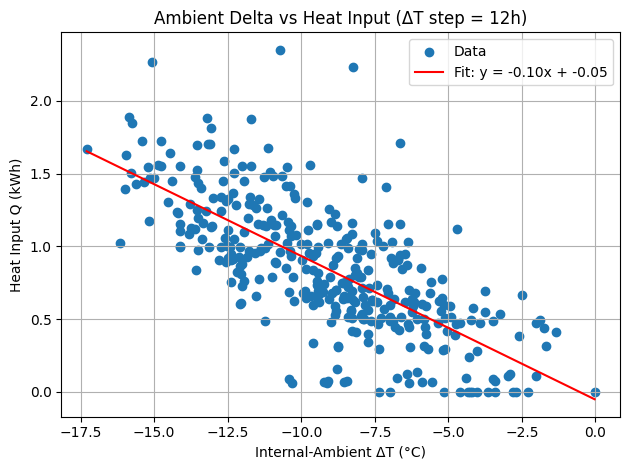

In [10]:
t_step_regres = 12


# Select numeric columns and resample
df_numeric = df_heating_only.select_dtypes(include='number')
df_resampled = df_numeric.resample(f'{t_step_regres}h').mean()

# Extract variables
delta_T_a_heat = df_resampled["Internal_Ambient_Temperature_Diff"].dropna()
q_heat_only = df_resampled["Heat_Pump_Energy_Output_Diff"].dropna()

# Align lengths
valid_idx = delta_T_a_heat.index.intersection(q_heat_only.index)
delta_T_a_heat = delta_T_a_heat.loc[valid_idx]
q_heat_only = q_heat_only.loc[valid_idx]

# Regression (Y = a*X + b)
Y = q_heat_only.values
X = np.vstack([delta_T_a_heat.values, np.ones(len(delta_T_a_heat))]).T
coef, _, _, _ = np.linalg.lstsq(X, Y, rcond=None)

# Generate fit line
x_step = np.linspace(delta_T_a_heat.min(), delta_T_a_heat.max(), 100)
y_step = coef[0] * x_step + coef[1]

# Plot
plt.figure()
plt.scatter(delta_T_a_heat, q_heat_only, label="Data")
plt.plot(x_step, y_step, 'r', label=f"Fit: y = {coef[0]:.2f}x + {coef[1]:.2f}")
plt.title(f"Ambient Delta vs Heat Input (ΔT step = {t_step_regres}h)")
plt.xlabel("Internal-Ambient ΔT (°C)")
plt.ylabel("Heat Input Q (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
predicted = coef[0] * delta_T_a_heat.values + coef[1]

# Condition: actual > predicted
above_mask = q_heat_only.values > predicted

# Convert to DataFrame for easier handling
df_check = pd.DataFrame({
    "q_actual": q_heat_only.values,
    "q_predicted": predicted,
    "above_line": above_mask
}, index=delta_T_a_heat.index)

# Extract timestamps where actual > predicted
above_points = df_check[df_check["above_line"]].index

# Optionally, group into contiguous windows
df_check["group"] = (df_check["above_line"] != df_check["above_line"].shift()).cumsum()
above_windows = df_check[df_check["above_line"]].groupby("group").apply(
    lambda x: (x.index[0], x.index[-1])
)

print("All time windows above the regression line:")
print(above_windows.tolist())

All time windows above the regression line:
[(Timestamp('2021-10-01 00:00:00'), Timestamp('2021-10-01 00:00:00')), (Timestamp('2021-10-03 12:00:00'), Timestamp('2021-10-03 12:00:00')), (Timestamp('2021-10-05 12:00:00'), Timestamp('2021-10-06 00:00:00')), (Timestamp('2021-10-07 00:00:00'), Timestamp('2021-10-08 00:00:00')), (Timestamp('2021-10-15 12:00:00'), Timestamp('2021-10-16 12:00:00')), (Timestamp('2021-10-18 00:00:00'), Timestamp('2021-10-18 12:00:00')), (Timestamp('2021-10-19 12:00:00'), Timestamp('2021-10-19 12:00:00')), (Timestamp('2021-10-23 12:00:00'), Timestamp('2021-10-24 00:00:00')), (Timestamp('2021-10-26 00:00:00'), Timestamp('2021-10-27 00:00:00')), (Timestamp('2021-10-28 00:00:00'), Timestamp('2021-10-28 00:00:00')), (Timestamp('2021-11-01 00:00:00'), Timestamp('2021-11-01 12:00:00')), (Timestamp('2021-11-02 12:00:00'), Timestamp('2021-11-02 12:00:00')), (Timestamp('2021-11-03 12:00:00'), Timestamp('2021-11-03 12:00:00')), (Timestamp('2021-11-05 00:00:00'), Timestamp(

/var/folders/fk/0m0g9qgs7y5fc0br86wht_1m0000gn/T/ipykernel_56467/1887057185.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  above_windows = df_check[df_check["above_line"]].groupby("group").apply(
